In [1]:
#!pip install torchvision

# MNIST Neural Network from Scratch

**Author:** Sneha Chandra  
**Date:** February 2026  
**Goal:** Implement a 2-layer neural network without using PyTorch's autograd

## Results
- **Final Test Accuracy:** 97.91%
- **Final Loss:** 0.0185
- **Training Time:** ~15 minutes (10 epochs)

## Architecture
- Input: 784 pixels (28×28 flattened)
- Hidden Layer: 128 neurons with ReLU activation
- Output: 10 neurons (one per digit class)

## What I Learned
1. How forward propagation works (matrix multiplications + activations)
2. How backpropagation computes gradients (chain rule)
3. Why gradient batching is important (stability)
4. How neural networks actually learn (gradient descent)

## Key Implementation Details
- Batch gradient descent with batch size 64
- Learning rate: 0.1
- Loss function: Cross-entropy with softmax
- Numerical stability: Clamped probabilities to avoid log(0)

100%|██████████| 9.91M/9.91M [00:00<00:00, 43.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.63MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 11.1MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.26MB/s]


Image shape: torch.Size([1, 28, 28]) Label: 5


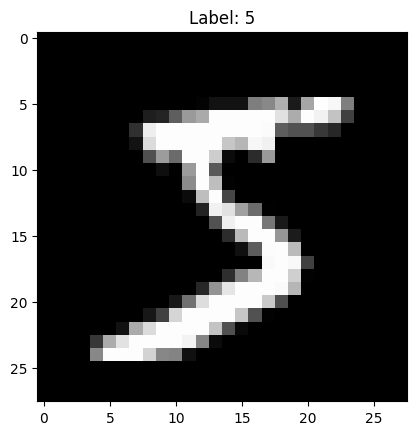

In [2]:
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms # Corrected imports
import matplotlib.pyplot as plt

# Load MNIST
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]) # MNIST mean and std

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

# one example check of data
x_sample, y_sample = train_dataset[0]
#f"Image : {x_sample}"
print(f"Image shape: {x_sample.shape}",f"Label: {y_sample}")

#Visualise
plt.imshow(x_sample.squeeze(), cmap='gray')
plt.title(f"Label: {y_sample}")
plt.show()


In [3]:
# Architecture: 784 → 128 → 10
input_size = 28 * 28  # 784
# Neural Network layers
hidden_size = 128
# Number of classes - (0-9) digits in MNIST
output_size = 10

# Initialize weights with small random values
W1 = torch.randn(input_size, hidden_size) * 0.01
b1 = torch.zeros(hidden_size)
W2 = torch.randn(hidden_size, output_size) * 0.01
b2 = torch.zeros(output_size)

print(f"W1 Shape: {W1.shape}", f"b1 Shape: {b1.shape}", f"W2 Shape: {W2.shape}", f"b2 Shape: {b2.shape}")

W1 Shape: torch.Size([784, 128]) b1 Shape: torch.Size([128]) W2 Shape: torch.Size([128, 10]) b2 Shape: torch.Size([10])


In [4]:
# Forward pass
def forward(x):
  """
    Performs the forward pass through the two-layer neural network.
    This function calculates the output scores (logits) for a given input image.

    Args:
        x: The input image tensor, flattened to shape (784,).
           This represents a single MNIST image with 28x28 pixels.

    Returns:
        z2: The raw output scores (logits) from the second layer, shape (10,).
            These scores represent the network's confidence for each of the 10 digit classes.
        h: The activations of the hidden layer after the ReLU function, shape (128,).
           This is needed for the backpropagation step.
        z1: The pre-activation values of the hidden layer (before ReLU), shape (128,).
            This is also needed for backpropagation to calculate the ReLU gradient.
    """
  # Layer 1: Linear transformation (Input Layer to Hidden Layer)
  # Operation: z1 = x @ W1 + b1
  # This is the core linear transformation. The input features (x) are multiplied by the
  # weight matrix W1 and then the bias vector b1 is added.
  # Choice: We use matrix multiplication (@) for efficiency and to correctly combine
  # the input features with the learned weights.
  # Insight: This step combines all input pixel information, weighted by W1, to produce
  # a weighted sum for each neuron in the hidden layer. b1 shifts these sums.
  z1 = x @ W1 + b1

  # Apply ReLU (Rectified Linear Unit) activation to the hidden layer.
  # Operation: h = max(0, z1)
  # ReLU introduces non-linearity into the network, allowing it to learn complex, non-linear relationships
  # in the data that a purely linear model cannot. Without non-linear activations,
  # stacking multiple linear layers would still result in a single linear transformation.
  # Choice: ReLU is computationally efficient (just a max operation) and helps mitigate
  # the vanishing gradient problem compared to sigmoid or tanh for deep networks.
  # Insight: Non-linearity is essential for neural networks to model real-world data.
  h = F.relu(z1)

  # Layer 2: Linear transformation (Hidden Layer to Output Layer)
  # Operation: z2 = h @ W2 + b2
  # Similar to the first layer, the activations from the hidden layer (h) are multiplied
  # by the weight matrix W2 and the bias vector b2 is added.
  # Choice: This final linear layer transforms the learned features from the hidden layer
  # into raw scores for each of the 10 output classes.
  # Insight: The output of this layer (z2) represents the unnormalized 'strength' or 'score'
  # for each digit. These scores will later be converted into probabilities using Softmax.
  z2 = h @ W2 + b2

  return z2, h, z1

# Test forward pass with a sample image
x_test = x_sample.view(-1) # Flatten the 28x28 image to a 784-element vector
z2, h, z1 = forward(x_test)

print(f"Output scores shape: {z2.shape}")
print(f"Output scores: {z2}")

Output scores shape: torch.Size([10])
Output scores: tensor([ 0.0093, -0.0484, -0.0397,  0.0011, -0.0061, -0.0352, -0.0015,  0.0175,
         0.0218, -0.0049])


In [5]:
#Implement loss function
def cross_entropy_loss(scores, target):
    """
    Compute cross-entropy loss

    Args:
        scores: Raw scores from network, shape (10,) - these are the z2 outputs from the forward pass.
        target: True label (integer 0-9) - the correct class for the input image.

    Returns:
        loss: Scalar loss value - a measure of how far off the prediction is from the true label.
        probs: Softmax probabilities (10,) - the network's predicted probabilities for each class.
    """
    # Softmax: Convert raw scores (logits) into probabilities.
    # F.softmax applies the exponential function to each score and then normalizes them,
    # so they sum to 1. This converts arbitrary scores into a probability distribution.
    # Insight: Softmax is crucial for interpreting model outputs as probabilities and is
    # often paired with cross-entropy loss for multi-class classification.
    probs = F.softmax(scores, dim=0)

    # Add small epsilon to prevent log(0).
    # If a probability becomes exactly 0, taking its logarithm results in negative infinity,
    # which can cause numerical instability (NaNs) during training. Clamping ensures
    # probabilities stay within a very small but non-zero range.
    # Choice: Using a small epsilon (1e-10) is a common practice for numerical stability.
    epsilon = 1e-10
    probs = torch.clamp(probs, epsilon, 1.0 - epsilon)

    # Cross-entropy: -log(probability of correct class).
    # The cross-entropy loss measures the performance of a classification model whose
    # output is a probability value between 0 and 1. It increases as the predicted
    # probability diverges from the actual label.
    # For a single sample, it simplifies to -log(p_true), where p_true is the probability
    # assigned by the model to the true class.
    # Insight: Minimizing cross-entropy loss encourages the model to output high probabilities
    # for the correct class and low probabilities for incorrect classes.
    loss = -torch.log(probs[target])

    return loss, probs

# Test loss with the sample output and label
loss, probs = cross_entropy_loss(z2, y_sample)
print(f"Loss: {loss.item()}")
print(f"Probabilities: {probs}")
print(f"Predicted class: {probs.argmax()}")
print(f"True class: {y_sample}")

Loss: 2.329439401626587
Probabilities: tensor([0.1018, 0.0961, 0.0969, 0.1010, 0.1002, 0.0974, 0.1007, 0.1026, 0.1031,
        0.1003])
Predicted class: 8
True class: 5


In [6]:
# backward pass

def backward(x, target, z2, h, z1, probs):
    """
    Backward pass - compute all gradients for a single data point.

    Args:
        x: Input image (784,) - The original flattened input image.
        target: True label (integer 0-9) - The correct class for the input image.
        z2: Pre-softmax scores (10,) - The raw outputs from the second linear layer (forward pass).
        h: Hidden activations (128,) - The activations of the hidden layer after ReLU (forward pass).
        z1: Pre-ReLU hidden (128,) - The pre-activation values of the hidden layer (forward pass).
        probs: Softmax probabilities (10,) - The predicted probabilities from the loss function.

    Returns:
        dW2, db2, dW1, db1: Gradients for all parameters (W1, b1, W2, b2).
                          These gradients indicate how much each parameter should change
                          to reduce the loss.
    """
    # Step 1: Gradient of the loss with respect to the pre-softmax scores (dL_dz2).
    # This combines the gradients from the cross-entropy loss and the softmax function.
    # The formula `probs - one_hot` is a common shortcut for this combined gradient
    # when using cross-entropy with softmax. 'one_hot' is a vector with 1 at the target
    # class index and 0 elsewhere.
    # Insight: This derivative tells us how much we need to change each logit (z2) to reduce the loss.
    one_hot = torch.zeros_like(probs)
    one_hot[target] = 1.0
    dL_dz2 = probs - one_hot

    # Step 2: Gradients for the output layer weights (W2) and bias (b2).
    # dL_dW2: The gradient of the loss with respect to W2. This is computed by the outer product
    #         of the hidden layer activations (h) and the gradient dL_dz2. Each element (i, j)
    #         of dL_dW2 represents dL/dW2_ij = h_i * dL/dz2_j.
    # dL_db2: The gradient of the loss with respect to b2. Since each element of b2 directly
    #         adds to an element of z2, its gradient is simply dL_dz2.
    # Choice: Using `torch.outer` efficiently computes the outer product for dW2.
    dL_dW2 = torch.outer(h, dL_dz2)
    dL_db2 = dL_dz2

    # Step 3: Gradient flowing back to the hidden layer activations (dL_dh).
    # This is calculated using the chain rule: dL/dh = (dL/dz2) @ (dz2/dh).
    # dz2/dh is simply W2.T (transpose of W2), as z2 = h @ W2 + b2.
    # Insight: This tells us how much each hidden unit's activation contributes to the overall loss.
    dL_dh = dL_dz2 @ W2.T

    # Step 4: Gradient through the ReLU activation function (dL_dz1).
    # The derivative of ReLU is 1 if the input (z1) was positive, and 0 otherwise.
    # So, we multiply dL_dh by `relu_grad` (an element-wise mask) to propagate gradients
    # only through active neurons.
    # Choice: `(z1 > 0).float()` creates a binary mask (1.0 where z1 > 0, else 0.0).
    # Insight: ReLU's simple derivative helps prevent vanishing gradients for positive activations.
    relu_grad = (z1 > 0).float()
    dL_dz1 = dL_dh * relu_grad

    # Step 5: Gradients for the input layer weights (W1) and bias (b1).
    # dL_dW1: The gradient of the loss with respect to W1. Similar to dL_dW2, it's the outer product
    #         of the input features (x) and the gradient dL_dz1.
    # dL_db1: The gradient of the loss with respect to b1. Its gradient is simply dL_dz1.
    # Insight: These gradients guide the updates for the first layer's parameters.
    dL_dW1 = torch.outer(x, dL_dz1)
    dL_db1 = dL_dz1

    return dL_dW1, dL_db1, dL_dW2, dL_db2



# Test backward pass
x_test = x_sample.view(-1)
z2, h, z1 = forward(x_test)
loss, probs = cross_entropy_loss(z2, y_sample)

dW1, db1, dW2, db2 = backward(x_test, y_sample, z2, h, z1, probs)

# Verify shapes
print(f"dW1 shape: {dW1.shape} (should be {W1.shape})")
print(f"db1 shape: {db1.shape} (should be {b1.shape})")
print(f"dW2 shape: {dW2.shape} (should be {W2.shape})")
print(f"db2 shape: {db2.shape} (should be {b2.shape})")

# Check gradients aren't NaN or all zeros
print(f"\ndW2 sample values: {dW2[0, :5]}")
print(f"dW1 sample values: {dW1[0, :5]}")

dW1 shape: torch.Size([784, 128]) (should be torch.Size([784, 128]))
db1 shape: torch.Size([128]) (should be torch.Size([128]))
dW2 shape: torch.Size([128, 10]) (should be torch.Size([128, 10]))
db2 shape: torch.Size([10]) (should be torch.Size([10]))

dW2 sample values: tensor([0., 0., 0., 0., 0.])
dW1 sample values: tensor([-0.0000,  0.0002, -0.0000,  0.0000, -0.0044])


In [7]:
# Implement SGD Weight Update

def sgd_update(W, dW, learning_rate):
    """
    Performs a Stochastic Gradient Descent (SGD) weight update.

    Args:
        W: The current weight tensor (e.g., W1 or W2).
        dW: The gradient of the loss with respect to the weight tensor W (e.g., dW1 or dW2).
        learning_rate: A scalar value determining the step size for the update.

    Returns:
        W_new: The updated weight tensor after applying the SGD step.

    Explanation:
    The core idea of SGD is to adjust the model's parameters (weights and biases)
    in the direction that reduces the loss function. The gradient (dW) indicates
    the direction of the steepest ascent of the loss function. To minimize the loss,
    we move in the opposite direction of the gradient.

    The formula for the update is: W_new = W - learning_rate * dW.
    - `W`: The current value of the parameter.
    - `learning_rate`: A hyperparameter that controls how large each step should be.
                       A smaller learning rate means smaller steps and slower convergence
                       but can lead to more stable training and potentially better optima.
                       A larger learning rate can speed up convergence but risks overshooting
                       the minimum or causing oscillations.
    - `dW`: The calculated gradient for the parameter, telling us the slope of the loss
            function with respect to this parameter.

    Insight: This function embodies the fundamental learning mechanism in many neural networks.
    By repeatedly applying this update based on gradients computed from batches of data,
    the network gradually learns to make better predictions.
    """

    W_new = W - learning_rate * dW

    return W_new

# Test it
learning_rate = 0.01
W1_new = sgd_update(W1, dW1, learning_rate)
print(f"Weight changed by: {(W1_new - W1).abs().mean().item()}")

Weight changed by: 2.8197213396197185e-05


In [8]:
from torch.utils.data import DataLoader

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Number of batches in train_loader: {len(train_loader)}")
print(f"Number of batches in test_loader: {len(test_loader)}")
print(f"Images per batch in train_loader: {train_loader.batch_size}")
print(f"Images per batch in test_loader: {test_loader.batch_size}")


Number of batches in train_loader: 938
Number of batches in test_loader: 157
Images per batch in train_loader: 64
Images per batch in test_loader: 64


In [9]:
# Training Loop (Single Epoch First)

# Hyperparameters
learning_rate = 0.1
num_epochs = 1  # Start with 1 epoch

# Training
total_loss = 0
num_batches = 0

for batch_idx, (images, labels) in enumerate(train_loader):
  # Process each image in the batch
  batch_loss = 0

  for i in range(images.shape[0]):
    # Get single image and label
    x = images[i].view(-1)  # Flatten to (784,)
    target = labels[i].item()

    # Forward pass
    z2, h, z1 = forward(x)

    # Compute loss
    loss, probs = cross_entropy_loss(z2, target)
    batch_loss += loss.item()

    # Backward pass
    dW1, db1, dW2, db2 = backward(x, target, z2, h, z1, probs)

    # Update weights
    W1 = sgd_update(W1, dW1, learning_rate)
    b1 = sgd_update(b1, db1, learning_rate)
    W2 = sgd_update(W2, dW2, learning_rate)
    b2 = sgd_update(b2, db2, learning_rate)

  # Track statistics
  total_loss += batch_loss/images.shape[0]
  num_batches += 1

  # Print progress every 100 batches
  if (batch_idx + 1) % 100 == 0:
      avg_loss = total_loss / num_batches
      print(f"Batch {batch_idx + 1}/{len(train_loader)}, Avg Loss: {avg_loss:.4f}")
      total_loss = 0
      num_batches = 0

print("Epoch 1 complete!")

Batch 100/938, Avg Loss: 2.3773
Batch 200/938, Avg Loss: 2.3313
Batch 300/938, Avg Loss: 2.3189
Batch 400/938, Avg Loss: 2.3311
Batch 500/938, Avg Loss: 2.3108
Batch 600/938, Avg Loss: 2.3243
Batch 700/938, Avg Loss: 2.3131
Batch 800/938, Avg Loss: 2.3347
Batch 900/938, Avg Loss: 2.3145
Epoch 1 complete!


In [10]:
# Evaluation Function

def evaluate(test_loader):
    """
    Evaluate model on test set

    Returns:
        accuracy: Percentage of correct predictions
    """
    correct = 0
    total = 0

    for images, labels in test_loader:
        for i in range(images.shape[0]):
            x = images[i].view(-1)
            target = labels[i].item()

            # Forward pass only (no backward)
            z2, h, z1 = forward(x)

            # Get prediction
            prediction = z2.argmax().item()

            if prediction == target:
                correct += 1
            total += 1

    accuracy = 100.0 * correct / total
    return accuracy

# Test it after 1 epoch
test_accuracy = evaluate(test_loader)
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 11.39%


In [11]:
# Re-initialize weights (start fresh)
W1 = torch.randn(input_size, hidden_size) * 0.01
b1 = torch.zeros(hidden_size)
W2 = torch.randn(hidden_size, output_size) * 0.01
b2 = torch.zeros(output_size)

learning_rate = 0.1  # Can use 0.1 now that we're batching properly
num_epochs = 10

# Lists to store metrics for plotting
epoch_losses = []
epoch_accuracies = []

print("Starting training...")
print(f"Initial test accuracy: {evaluate(test_loader):.2f}%\n")

for epoch in range(num_epochs):
    total_loss = 0
    num_batches = 0

    # Training
    for batch_idx, (images, labels) in enumerate(train_loader):
        batch_size_actual = images.shape[0]
        batch_loss = 0

        # INITIALIZE gradient accumulators
        accumulated_dW1 = torch.zeros_like(W1)
        accumulated_db1 = torch.zeros_like(b1)
        accumulated_dW2 = torch.zeros_like(W2)
        accumulated_db2 = torch.zeros_like(b2)

        # Process each image in the batch
        for i in range(batch_size_actual):
            x = images[i].view(-1)
            target = labels[i].item()

            # Forward
            z2, h, z1 = forward(x)
            loss, probs = cross_entropy_loss(z2, target)
            batch_loss += loss.item()

            # Backward
            dW1, db1, dW2, db2 = backward(x, target, z2, h, z1, probs)

            # ACCUMULATE gradients (don't update yet!)
            accumulated_dW1 += dW1
            accumulated_db1 += db1
            accumulated_dW2 += dW2
            accumulated_db2 += db2

        # AVERAGE gradients over batch
        accumulated_dW1 /= batch_size_actual
        accumulated_db1 /= batch_size_actual
        accumulated_dW2 /= batch_size_actual
        accumulated_db2 /= batch_size_actual

        # UPDATE weights ONCE per batch
        W1 = sgd_update(W1, accumulated_dW1, learning_rate)
        b1 = sgd_update(b1, accumulated_db1, learning_rate)
        W2 = sgd_update(W2, accumulated_dW2, learning_rate)
        b2 = sgd_update(b2, accumulated_db2, learning_rate)

        # Track statistics
        total_loss += batch_loss / batch_size_actual
        num_batches += 1

    # Evaluate after each epoch
    avg_loss = total_loss / num_batches
    test_acc = evaluate(test_loader)

    # Store metrics
    epoch_losses.append(avg_loss)
    epoch_accuracies.append(test_acc)

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

print("\nTraining complete!")

Starting training...
Initial test accuracy: 9.19%

Epoch 1/10 - Loss: 0.3123, Test Accuracy: 95.51%
Epoch 2/10 - Loss: 0.1267, Test Accuracy: 96.69%
Epoch 3/10 - Loss: 0.0872, Test Accuracy: 97.14%
Epoch 4/10 - Loss: 0.0675, Test Accuracy: 97.66%
Epoch 5/10 - Loss: 0.0539, Test Accuracy: 97.64%
Epoch 6/10 - Loss: 0.0427, Test Accuracy: 97.76%
Epoch 7/10 - Loss: 0.0351, Test Accuracy: 97.94%
Epoch 8/10 - Loss: 0.0284, Test Accuracy: 97.11%
Epoch 9/10 - Loss: 0.0232, Test Accuracy: 98.07%
Epoch 10/10 - Loss: 0.0191, Test Accuracy: 98.02%

Training complete!


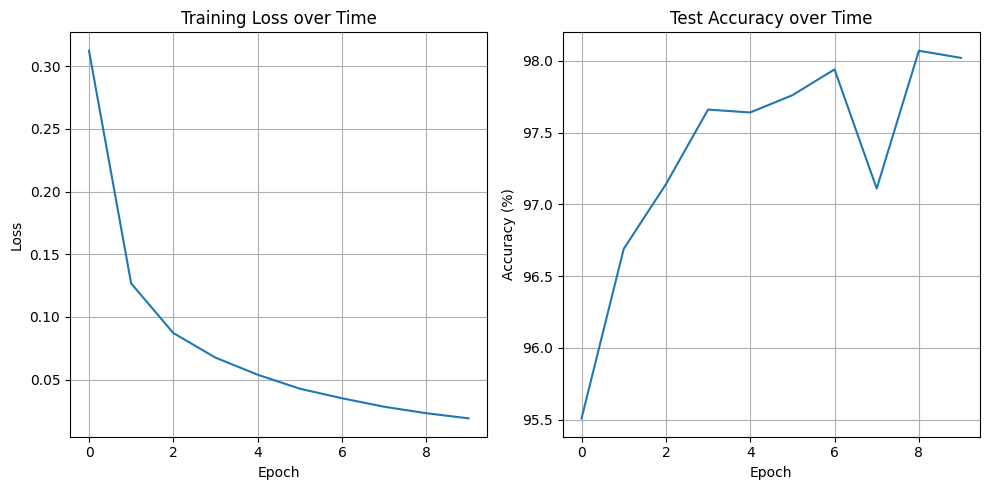

In [12]:
# You'll need to modify training loop to save losses
import matplotlib.pyplot as plt

# Create plot
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(epoch_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Time')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epoch_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy over Time')
plt.grid(True)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

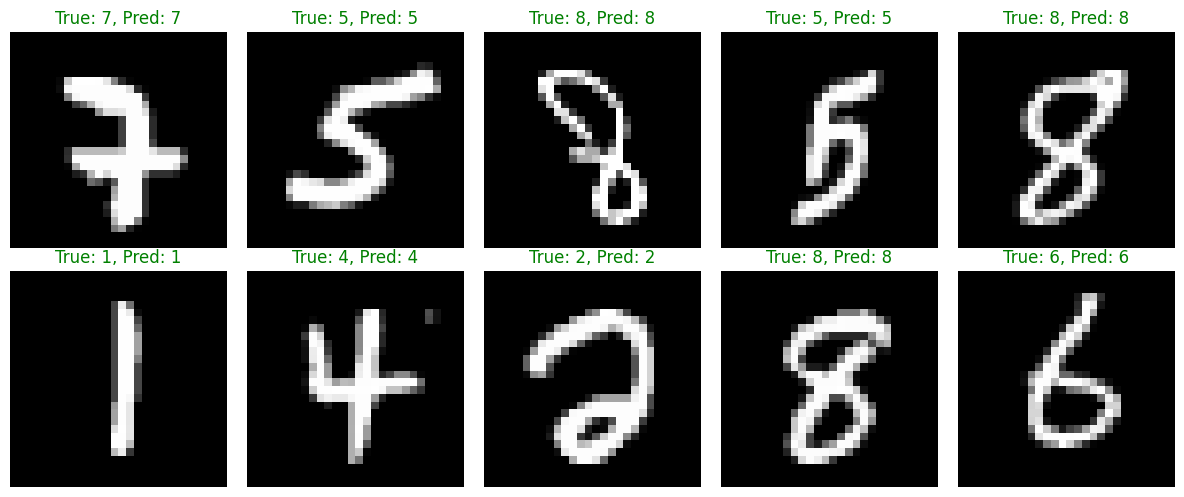

In [13]:
# Visualize predictions on test set
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.ravel()

for i in range(10):
    # Get random test image
    idx = torch.randint(0, len(test_dataset), (1,)).item()
    image, true_label = test_dataset[idx]

    # Predict
    x = image.view(-1)
    z2, h, z1 = forward(x)
    prediction = z2.argmax().item()

    # Plot
    axes[i].imshow(image.squeeze(), cmap='gray')
    axes[i].set_title(f'True: {true_label}, Pred: {prediction}',
                      color='green' if prediction == true_label else 'red')
    axes[i].axis('off')

plt.tight_layout()
plt.savefig('predictions.png', dpi=150, bbox_inches='tight')
plt.show()